In [145]:
import os
import shutil

import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
font = {'size': 16}
matplotlib.rc('font', **font)
from scipy.stats import norm, skewnorm, gamma
import torch
import random

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [5]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [6]:
from koopman_probabilistic import *
from gefcom_koopman import GEFComKoopman
from model_objs import *
import vanilla_benchmark

In [12]:
data_directory = '..\..\Documents\\2021_winter\AMATH582\AMATH-582\\allenSDK\ecephys_cache' # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

In [13]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [14]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

Total number of sessions: 58


In [15]:
filtered_sessions = sessions[(sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

print(len(filtered_sessions))
filtered_sessions.head()

6


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


In [16]:
session_id = 715093703  # based on the above filter
session = cache.get_session_data(session_id)

In [17]:
units = cache.get_units()

In [18]:
unit_ids = units[(units.ecephys_structure_acronym=="VISp") & (units.specimen_id==filtered_sessions.specimen_id[session_id])].index
unit_ids.shape

(60,)

# Get natural movie data

In [48]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="natural_movie_one"]
stim = session.get_stimulus_table(['natural_movie_one'])
stim_pres_ids = stim.index

In [54]:
stim

,contrast,frame,orientation,size,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,
22000,1,0,0,"[1920.0, 1080.0]",2835.861733,4,natural_movie_one,2835.895094,0.033361,3887
22001,1,1,0,"[1920.0, 1080.0]",2835.895094,4,natural_movie_one,2835.928455,0.033361,3888
22002,1,2,0,"[1920.0, 1080.0]",2835.928455,4,natural_movie_one,2835.961816,0.033361,3889
22003,1,3,0,"[1920.0, 1080.0]",2835.961816,4,natural_movie_one,2835.995178,0.033361,3890
22004,1,4,0,"[1920.0, 1080.0]",2835.995178,4,natural_movie_one,2836.028539,0.033361,3891
...,...,...,...,...,...,...,...,...,...,...
66111,1,895,0,"[1920.0, 1080.0]",7994.020482,12,natural_movie_one,7994.053842,0.033360,4782
66112,1,896,0,"[1920.0, 1080.0]",7994.053842,12,natural_movie_one,7994.087202,0.033360,4783
66113,1,897,0,"[1920.0, 1080.0]",7994.087202,12,natural_movie_one,7994.120563,0.033360,4784


In [55]:
times = session.presentationwise_spike_times(stimulus_presentation_ids=stim_pres_ids,
                                             unit_ids=unit_ids)

In [138]:
num_presentations = 10
num_bins = 1000 * num_presentations
stim_length = 30  # seconds for natural movie one
# stim_length = 120  # seconds for natural movie three
start_time = stim.iloc[0].start_time
end_time = start_time + stim_length * num_presentations
stim_range = np.array([start_time, end_time])
possible_times = times.iloc[(start_time <= times.index) & (times.index < end_time)]

responses = np.zeros((num_bins, len(unit_ids)))
bin_edges = np.linspace(0, stim_length * num_presentations, num_bins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_width = bin_edges[1] - bin_edges[0]

for j, unit_id in enumerate(unit_ids):
    times_j = possible_times[possible_times.unit_id==unit_id].index
    responses[:, j] = np.histogram(times_j, num_bins, range=stim_range)[0]
#     # 1st block where nat 1 is shown, it is shown 10 times in each block
#     presentations1 = stim_epochs.iloc[0].start_time + np.linspace(0, stim_epochs.iloc[0].duration, 10)
#     # 2nd block
#     presentations2 = stim_epochs.iloc[1].start_time + np.linspace(0, stim_epochs.iloc[1].duration, 10)
#     presentations = np.concatenate([presentations1, presentations2])
#     for i, start in enumerate(presentations):
#         times_ij = times[(times.unit_id==unit_id) & (start < times.index) & (times.index < (start + stim_length))].index
#         unit_counts, _ = np.histogram(times_ij, num_bins, range=start + stim_range)
#         trials[i, :, j] = unit_counts

In [139]:
avg_resp = responses.mean(axis=1)
avg_resp_c = avg_resp - avg_resp.mean(axis=0, keepdims=True)

<IPython.core.display.Javascript object>


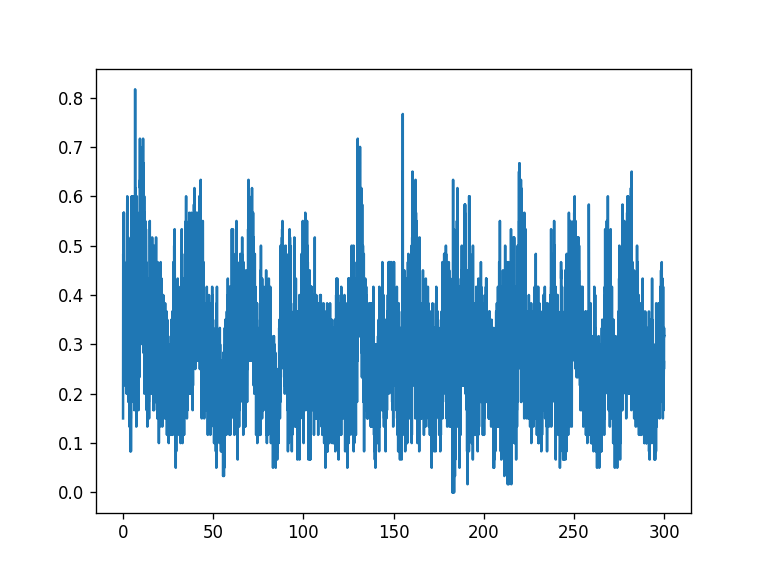

In [140]:
%matplotlib notebook
plt.plot(bin_centers, avg_resp)

In [141]:
stim_range

array([2835.86173294, 3135.86173294])

# Run koopman analysis

In [143]:
x = avg_resp.reshape(-1, 1)
x.shape

(10000, 1)

In [146]:
x_original = x
mean = np.mean(x, axis=0)
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = (x - np.matlib.repmat(mean, x.shape[0], 1)) / np.matlib.repmat(rnge, x.shape[0], 1)
print("x", x.shape)

x (10000, 1)


In [147]:
data_name = "neuralAvgNat1"

train_through = 10000
train_start = 0
delay = 0
test_length = 5000
x = x[train_start:]
predict_through = train_through + test_length + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [5, 5, 5]
num_fourier = 5
hard_code = [x.shape[0] / num_presentations]
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
print("x", x.shape)
print("xt", xt.shape)

x (10000, 1)
xt (10000, 1)


In [148]:
model = SkewNormalNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [149]:
k.find_fourier_omegas(xt, hard_code=hard_code)

fourier periods: tensor([1111.1111,  500.0000,  344.8276,  204.0816,  999.9999],
       dtype=torch.float64)


tensor([0.0057, 0.0126, 0.0182, 0.0308, 0.0063], dtype=torch.float64)

In [150]:
k.fit(xt, iterations=300, interval=10, verbose=True, cutoff=0, weight_decay=0, lr_theta=1e-4, lr_omega=1e-6);

Iteration  0
tensor([1111.1111,  500.0000,  344.8276,  204.0816,  999.9999, 1111.1111,
         500.0000,  344.8276,  204.0816,  999.9999, 1111.1111,  500.0000,
         344.8276,  204.0816,  999.9999])
Setting periods to tensor([1111.1097,  500.0000,  344.8276,  204.0816,  999.9999, 1111.1449,
         499.9995,  344.8261,  204.0823,  999.9795, 1111.1111,  500.0000,
         344.8276,  204.0816, 1000.0015], grad_fn=<MulBackward0>)
Loss:  2.571824523246222
Iteration  1
tensor([1111.1097,  500.0000,  344.8276,  204.0816,  999.9999, 1111.1449,
         499.9995,  344.8261,  204.0823,  999.9795, 1111.1111,  500.0000,
         344.8276,  204.0816, 1000.0015])
Setting periods to tensor([1111.1074,  500.0000,  344.8276,  204.0816,  999.9999, 1111.1775,
         499.9985,  344.8245,  204.0831,  999.9586, 1111.1111,  500.0000,
         344.8276,  204.0816, 1000.0037], grad_fn=<MulBackward0>)
Loss:  2.5114141249716337
Iteration  2
tensor([1111.1074,  500.0000,  344.8276,  204.0816,  999.9999, 1

Setting periods to tensor([1110.5166,  499.9525,  344.8085,  204.0559, 1000.2922, 1111.8035,
         499.7679,  344.7999,  204.1199,  998.9200, 1111.2740,  500.0723,
         344.8269,  204.1152, 1000.3279], grad_fn=<MulBackward0>)
Loss:  -0.14735726677178082
Iteration  19
tensor([1110.5166,  499.9525,  344.8085,  204.0559, 1000.2922, 1111.8035,
         499.7679,  344.7999,  204.1199,  998.9200, 1111.2740,  500.0723,
         344.8269,  204.1152, 1000.3279])
Setting periods to tensor([1110.3733,  499.9272,  344.8015,  204.0534, 1000.4683, 1111.9031,
         499.7223,  344.8051,  204.1243,  998.7136, 1111.3130,  500.0849,
         344.8257,  204.1204, 1000.3904], grad_fn=<MulBackward0>)
Loss:  -0.4388891036030007
Iteration  20
tensor([1110.3733,  499.9272,  344.8015,  204.0534, 1000.4683, 1111.9031,
         499.7223,  344.8051,  204.1243,  998.7136, 1111.3130,  500.0849,
         344.8257,  204.1204, 1000.3904])
Setting periods to tensor([1110.2469,  499.9081,  344.7993,  204.0527, 

Setting periods to tensor([1108.5244,  499.3938,  344.7979,  204.1051, 1002.3682, 1113.4193,
         499.4153,  344.7865,  204.1651,  996.3123, 1111.4636,  500.2584,
         344.7864,  204.0926, 1000.3906], grad_fn=<MulBackward0>)
Loss:  -1.0094114104430407
Iteration  37
tensor([1108.5244,  499.3938,  344.7979,  204.1051, 1002.3682, 1113.4193,
         499.4153,  344.7865,  204.1651,  996.3123, 1111.4636,  500.2584,
         344.7864,  204.0926, 1000.3906])
Setting periods to tensor([1108.4542,  499.3716,  344.7990,  204.1091, 1002.4570, 1113.4567,
         499.4184,  344.7884,  204.1644,  996.3143, 1111.4656,  500.2702,
         344.7838,  204.0904, 1000.3852], grad_fn=<MulBackward0>)
Loss:  -1.0102342652033696
Iteration  38
tensor([1108.4542,  499.3716,  344.7990,  204.1091, 1002.4570, 1113.4567,
         499.4184,  344.7884,  204.1644,  996.3143, 1111.4656,  500.2702,
         344.7838,  204.0904, 1000.3852])
Setting periods to tensor([1108.3955,  499.3371,  344.7978,  204.1136, 1

Setting periods to tensor([1107.7711,  499.0512,  344.8085,  204.1684, 1003.3371, 1114.0491,
         499.5128,  344.8331,  204.1434,  996.6088, 1111.4313,  500.5027,
         344.7495,  204.0558, 1000.2722], grad_fn=<MulBackward0>)
Loss:  -1.0227022301633912
Iteration  55
tensor([1107.7711,  499.0512,  344.8085,  204.1684, 1003.3371, 1114.0491,
         499.5128,  344.8331,  204.1434,  996.6088, 1111.4313,  500.5027,
         344.7495,  204.0558, 1000.2722])
Setting periods to tensor([1107.7577,  499.0469,  344.8108,  204.1708, 1003.3466, 1114.0798,
         499.5185,  344.8365,  204.1419,  996.6356, 1111.4319,  500.5157,
         344.7477,  204.0537, 1000.2690], grad_fn=<MulBackward0>)
Loss:  -1.023150884258221
Iteration  56
tensor([1107.7577,  499.0469,  344.8108,  204.1708, 1003.3466, 1114.0798,
         499.5185,  344.8365,  204.1419,  996.6356, 1111.4319,  500.5157,
         344.7477,  204.0537, 1000.2690])
Setting periods to tensor([1107.7450,  499.0354,  344.8120,  204.1738, 10

Setting periods to tensor([1107.6818,  498.9190,  344.8238,  204.2087, 1003.4518, 1114.6105,
         499.6103,  344.8844,  204.1192,  997.0594, 1111.3673,  500.7481,
         344.7212,  204.0220, 1000.1442], grad_fn=<MulBackward0>)
Loss:  -1.033049023616773
Iteration  73
tensor([1107.6818,  498.9190,  344.8238,  204.2087, 1003.4518, 1114.6105,
         499.6103,  344.8844,  204.1192,  997.0594, 1111.3673,  500.7481,
         344.7212,  204.0220, 1000.1442])
Setting periods to tensor([1107.6860,  498.9161,  344.8230,  204.2104, 1003.4569, 1114.6404,
         499.6143,  344.8869,  204.1180,  997.0838, 1111.3640,  500.7623,
         344.7202,  204.0205, 1000.1392], grad_fn=<MulBackward0>)
Loss:  -1.0336660028353923
Iteration  74
tensor([1107.6860,  498.9161,  344.8230,  204.2104, 1003.4569, 1114.6404,
         499.6143,  344.8869,  204.1180,  997.0838, 1111.3640,  500.7623,
         344.7202,  204.0205, 1000.1392])
Setting periods to tensor([1107.6697,  498.9092,  344.8256,  204.2123, 10

Setting periods to tensor([1107.7764,  498.8792,  344.8400,  204.2332, 1003.1784, 1115.0824,
         499.6822,  344.9392,  204.0962,  997.4851, 1111.2910,  500.9880,
         344.6996,  203.9904, 1000.0398], grad_fn=<MulBackward0>)
Loss:  -1.041643560045334
Iteration  91
tensor([1107.7764,  498.8792,  344.8400,  204.2332, 1003.1784, 1115.0824,
         499.6822,  344.9392,  204.0962,  997.4851, 1111.2910,  500.9880,
         344.6996,  203.9904, 1000.0398])
Setting periods to tensor([1107.8082,  498.8917,  344.8416,  204.2345, 1003.1787, 1115.1057,
         499.6863,  344.9424,  204.0950,  997.5086, 1111.2836,  501.0007,
         344.6983,  203.9887, 1000.0355], grad_fn=<MulBackward0>)
Loss:  -1.0411064987522194
Iteration  92
tensor([1107.8082,  498.8917,  344.8416,  204.2345, 1003.1787, 1115.1057,
         499.6863,  344.9424,  204.0950,  997.5086, 1111.2836,  501.0007,
         344.6983,  203.9887, 1000.0355])
Setting periods to tensor([1107.7722,  498.8824,  344.8430,  204.2353, 10

Setting periods to tensor([1107.7998,  498.8787,  344.8551,  204.2505, 1002.7357, 1115.5007,
         499.7414,  344.9959,  204.0739,  997.9660, 1111.2076,  501.2154,
         344.6825,  203.9619,  999.9555], grad_fn=<MulBackward0>)
Loss:  -1.0483514150610478
Iteration  109
tensor([1107.7998,  498.8787,  344.8551,  204.2505, 1002.7357, 1115.5007,
         499.7414,  344.9959,  204.0739,  997.9660, 1111.2076,  501.2154,
         344.6825,  203.9619,  999.9555])
Setting periods to tensor([1107.7791,  498.8763,  344.8551,  204.2513, 1002.7172, 1115.5236,
         499.7446,  344.9989,  204.0725,  997.9923, 1111.1992,  501.2278,
         344.6818,  203.9607,  999.9506], grad_fn=<MulBackward0>)
Loss:  -1.048255171217346
Iteration  110
tensor([1107.7791,  498.8763,  344.8551,  204.2513, 1002.7172, 1115.5236,
         499.7446,  344.9989,  204.0725,  997.9923, 1111.1992,  501.2278,
         344.6818,  203.9607,  999.9506])
Setting periods to tensor([1107.7653,  498.8841,  344.8561,  204.2518, 

Setting periods to tensor([1107.5126,  498.8847,  344.8647,  204.2637, 1002.2101, 1115.8531,
         499.7880,  345.0566,  204.0523,  998.4608, 1111.1113,  501.4257,
         344.6695,  203.9369,  999.8844], grad_fn=<MulBackward0>)
Loss:  -1.0539679159940676
Iteration  127
tensor([1107.5126,  498.8847,  344.8647,  204.2637, 1002.2101, 1115.8531,
         499.7880,  345.0566,  204.0523,  998.4608, 1111.1113,  501.4257,
         344.6695,  203.9369,  999.8844])
Setting periods to tensor([1107.4708,  498.8880,  344.8662,  204.2639, 1002.1931, 1115.8723,
         499.7906,  345.0598,  204.0511,  998.4854, 1111.1072,  501.4355,
         344.6691,  203.9359,  999.8860], grad_fn=<MulBackward0>)
Loss:  -1.0538184616281063
Iteration  128
tensor([1107.4708,  498.8880,  344.8662,  204.2639, 1002.1931, 1115.8723,
         499.7906,  345.0598,  204.0511,  998.4854, 1111.1072,  501.4355,
         344.6691,  203.9359,  999.8860])
Setting periods to tensor([1107.4678,  498.8952,  344.8672,  204.2646,

Setting periods to tensor([1106.8854,  498.8785,  344.8773,  204.2744, 1001.6343, 1116.1671,
         499.8283,  345.1195,  204.0311,  998.9567, 1111.0254,  501.6178,
         344.6600,  203.9167,  999.8377], grad_fn=<MulBackward0>)
Loss:  -1.0589431568354155
Iteration  145
tensor([1106.8854,  498.8785,  344.8773,  204.2744, 1001.6343, 1116.1671,
         499.8283,  345.1195,  204.0311,  998.9567, 1111.0254,  501.6178,
         344.6600,  203.9167,  999.8377])
Setting periods to tensor([1106.8491,  498.8773,  344.8790,  204.2754, 1001.6305, 1116.1790,
         499.8302,  345.1236,  204.0300,  998.9848, 1111.0226,  501.6274,
         344.6595,  203.9154,  999.8374], grad_fn=<MulBackward0>)
Loss:  -1.0588625386765635
Iteration  146
tensor([1106.8491,  498.8773,  344.8790,  204.2754, 1001.6305, 1116.1790,
         499.8302,  345.1236,  204.0300,  998.9848, 1111.0226,  501.6274,
         344.6595,  203.9154,  999.8374])
Setting periods to tensor([1106.8151,  498.8793,  344.8798,  204.2762,

Setting periods to tensor([1106.0819,  498.8534,  344.8900,  204.2893, 1000.9866, 1116.4346,
         499.8665,  345.1861,  204.0098,  999.4260, 1110.9451,  501.7960,
         344.6515,  203.8993,  999.8072], grad_fn=<MulBackward0>)
Loss:  -1.0623943207262978
Iteration  163
tensor([1106.0819,  498.8534,  344.8900,  204.2893, 1000.9866, 1116.4346,
         499.8665,  345.1861,  204.0098,  999.4260, 1110.9451,  501.7960,
         344.6515,  203.8993,  999.8072])
Setting periods to tensor([1106.0356,  498.8604,  344.8910,  204.2900, 1000.9749, 1116.4491,
         499.8682,  345.1896,  204.0088,  999.4501, 1110.9354,  501.8051,
         344.6511,  203.8983,  999.8075], grad_fn=<MulBackward0>)
Loss:  -1.062254844076504
Iteration  164
tensor([1106.0356,  498.8604,  344.8910,  204.2900, 1000.9749, 1116.4491,
         499.8682,  345.1896,  204.0088,  999.4501, 1110.9354,  501.8051,
         344.6511,  203.8983,  999.8075])
Setting periods to tensor([1105.9844,  498.8483,  344.8918,  204.2905, 

Setting periods to tensor([1105.2415,  498.8273,  344.9002,  204.3066, 1000.2609, 1116.6782,
         499.9046,  345.2552,  203.9902,  999.8707, 1110.8547,  501.9643,
         344.6443,  203.8857,  999.7897], grad_fn=<MulBackward0>)
Loss:  -1.0656782979477604
Iteration  181
tensor([1105.2415,  498.8273,  344.9002,  204.3066, 1000.2609, 1116.6782,
         499.9046,  345.2552,  203.9902,  999.8707, 1110.8547,  501.9643,
         344.6443,  203.8857,  999.7897])
Setting periods to tensor([1105.1924,  498.8262,  344.8998,  204.3081, 1000.2847, 1116.6907,
         499.9061,  345.2588,  203.9891,  999.8929, 1110.8557,  501.9713,
         344.6440,  203.8847,  999.7905], grad_fn=<MulBackward0>)
Loss:  -1.0662492601862956
Iteration  182
tensor([1105.1924,  498.8262,  344.8998,  204.3081, 1000.2847, 1116.6907,
         499.9061,  345.2588,  203.9891,  999.8929, 1110.8557,  501.9713,
         344.6440,  203.8847,  999.7905])
Setting periods to tensor([1105.1703,  498.8263,  344.9012,  204.3093,

Setting periods to tensor([1104.4160,  498.7901,  344.9053,  204.3308,  999.5209, 1116.9012,
         499.9354,  345.3251,  203.9705, 1000.3209, 1110.7841,  502.1253,
         344.6364,  203.8762,  999.7854], grad_fn=<MulBackward0>)
Loss:  -1.0684810264485065
Iteration  199
tensor([1104.4160,  498.7901,  344.9053,  204.3308,  999.5209, 1116.9012,
         499.9354,  345.3251,  203.9705, 1000.3209, 1110.7841,  502.1253,
         344.6364,  203.8762,  999.7854])
Setting periods to tensor([1104.3295,  498.7892,  344.9071,  204.3320,  999.5092, 1116.9109,
         499.9369,  345.3288,  203.9693, 1000.3347, 1110.7789,  502.1350,
         344.6360,  203.8760,  999.7897], grad_fn=<MulBackward0>)
Loss:  -1.0683334126202826
Iteration  200
tensor([1104.3295,  498.7892,  344.9071,  204.3320,  999.5092, 1116.9109,
         499.9369,  345.3288,  203.9693, 1000.3347, 1110.7789,  502.1350,
         344.6360,  203.8760,  999.7897])
Setting periods to tensor([1104.3199,  498.7859,  344.9070,  204.3337,

Setting periods to tensor([1103.6620,  498.7350,  344.9045,  204.3577,  998.8163, 1117.0946,
         499.9643,  345.3966,  203.9495, 1000.7274, 1110.7118,  502.2788,
         344.6266,  203.8699,  999.7924], grad_fn=<MulBackward0>)
Loss:  -1.0714520049610086
Iteration  217
tensor([1103.6620,  498.7350,  344.9045,  204.3577,  998.8163, 1117.0946,
         499.9643,  345.3966,  203.9495, 1000.7274, 1110.7118,  502.2788,
         344.6266,  203.8699,  999.7924])
Setting periods to tensor([1103.6218,  498.7321,  344.9045,  204.3593,  998.8145, 1117.1086,
         499.9655,  345.4001,  203.9483, 1000.7505, 1110.7052,  502.2882,
         344.6259,  203.8700,  999.7952], grad_fn=<MulBackward0>)
Loss:  -1.0720993490038815
Iteration  218
tensor([1103.6218,  498.7321,  344.9045,  204.3593,  998.8145, 1117.1086,
         499.9655,  345.4001,  203.9483, 1000.7505, 1110.7052,  502.2882,
         344.6259,  203.8700,  999.7952])
Setting periods to tensor([1103.6007,  498.7299,  344.9048,  204.3607,

Setting periods to tensor([1103.1257,  498.6722,  344.9027,  204.3868,  998.1467, 1117.2938,
         499.9858,  345.4702,  203.9287, 1001.1274, 1110.6487,  502.4320,
         344.6158,  203.8675,  999.8051], grad_fn=<MulBackward0>)
Loss:  -1.0746423735498323
Iteration  235
tensor([1103.1257,  498.6722,  344.9027,  204.3868,  998.1467, 1117.2938,
         499.9858,  345.4702,  203.9287, 1001.1274, 1110.6487,  502.4320,
         344.6158,  203.8675,  999.8051])
Setting periods to tensor([1103.0927,  498.6646,  344.9021,  204.3890,  998.0880, 1117.3062,
         499.9877,  345.4743,  203.9276, 1001.1353, 1110.6420,  502.4378,
         344.6152,  203.8675,  999.8003], grad_fn=<MulBackward0>)
Loss:  -1.074320132988838
Iteration  236
tensor([1103.0927,  498.6646,  344.9021,  204.3890,  998.0880, 1117.3062,
         499.9877,  345.4743,  203.9276, 1001.1353, 1110.6420,  502.4378,
         344.6152,  203.8675,  999.8003])
Setting periods to tensor([1103.0487,  498.6709,  344.9020,  204.3904, 

Setting periods to tensor([1102.5856,  498.5916,  344.8940,  204.4190,  997.5164, 1117.4734,
         500.0035,  345.5416,  203.9086, 1001.4862, 1110.5902,  502.5793,
         344.6064,  203.8683,  999.8177], grad_fn=<MulBackward0>)
Loss:  -1.0762559834964682
Iteration  253
tensor([1102.5856,  498.5916,  344.8940,  204.4190,  997.5164, 1117.4734,
         500.0035,  345.5416,  203.9086, 1001.4862, 1110.5902,  502.5793,
         344.6064,  203.8683,  999.8177])
Setting periods to tensor([1102.5709,  498.5905,  344.8914,  204.4207,  997.5450, 1117.4852,
         500.0047,  345.5454,  203.9074, 1001.5108, 1110.5874,  502.5893,
         344.6055,  203.8688,  999.8167], grad_fn=<MulBackward0>)
Loss:  -1.0765094420407975
Iteration  254
tensor([1102.5709,  498.5905,  344.8914,  204.4207,  997.5450, 1117.4852,
         500.0047,  345.5454,  203.9074, 1001.5108, 1110.5874,  502.5893,
         344.6055,  203.8688,  999.8167])
Setting periods to tensor([1102.5540,  498.5860,  344.8894,  204.4229,

Setting periods to tensor([1102.1071,  498.5068,  344.8858,  204.4521,  997.0828, 1117.6722,
         500.0132,  345.6106,  203.8876, 1001.7991, 1110.5419,  502.7216,
         344.5951,  203.8723,  999.8304], grad_fn=<MulBackward0>)
Loss:  -1.0786267009976451
Iteration  271
tensor([1102.1071,  498.5068,  344.8858,  204.4521,  997.0828, 1117.6722,
         500.0132,  345.6106,  203.8876, 1001.7991, 1110.5419,  502.7216,
         344.5951,  203.8723,  999.8304])
Setting periods to tensor([1102.1018,  498.5095,  344.8854,  204.4535,  997.0373, 1117.6832,
         500.0131,  345.6142,  203.8867, 1001.8221, 1110.5361,  502.7292,
         344.5943,  203.8729,  999.8272], grad_fn=<MulBackward0>)
Loss:  -1.078672157482103
Iteration  272
tensor([1102.1018,  498.5095,  344.8854,  204.4535,  997.0373, 1117.6832,
         500.0131,  345.6142,  203.8867, 1001.8221, 1110.5361,  502.7292,
         344.5943,  203.8729,  999.8272])
Setting periods to tensor([1102.0741,  498.4968,  344.8830,  204.4550, 

Setting periods to tensor([1101.7262,  498.4030,  344.8813,  204.4872,  996.6179, 1117.8593,
         500.0213,  345.6808,  203.8681, 1002.0752, 1110.4958,  502.8549,
         344.5836,  203.8780,  999.8374], grad_fn=<MulBackward0>)
Loss:  -1.0809052409837048
Iteration  289
tensor([1101.7262,  498.4030,  344.8813,  204.4872,  996.6179, 1117.8593,
         500.0213,  345.6808,  203.8681, 1002.0752, 1110.4958,  502.8549,
         344.5836,  203.8780,  999.8374])
Setting periods to tensor([1101.6997,  498.3922,  344.8802,  204.4897,  996.5700, 1117.8708,
         500.0217,  345.6841,  203.8670, 1002.0927, 1110.4883,  502.8609,
         344.5830,  203.8782,  999.8364], grad_fn=<MulBackward0>)
Loss:  -1.08056918566519
Iteration  290
tensor([1101.6997,  498.3922,  344.8802,  204.4897,  996.5700, 1117.8708,
         500.0217,  345.6841,  203.8670, 1002.0927, 1110.4883,  502.8609,
         344.5830,  203.8782,  999.8364])
Setting periods to tensor([1101.7064,  498.3918,  344.8813,  204.4911,  

In [151]:
params = k.predict(predict_through)
mu_hat, sigma_hat, a_hat = params
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)
# params = k.predict(predict_through)
# mu_hat, sigma_hat = params
# np.save(mu_file, mu_hat)
# np.save(sigma_file, sigma_hat)

<IPython.core.display.Javascript object>


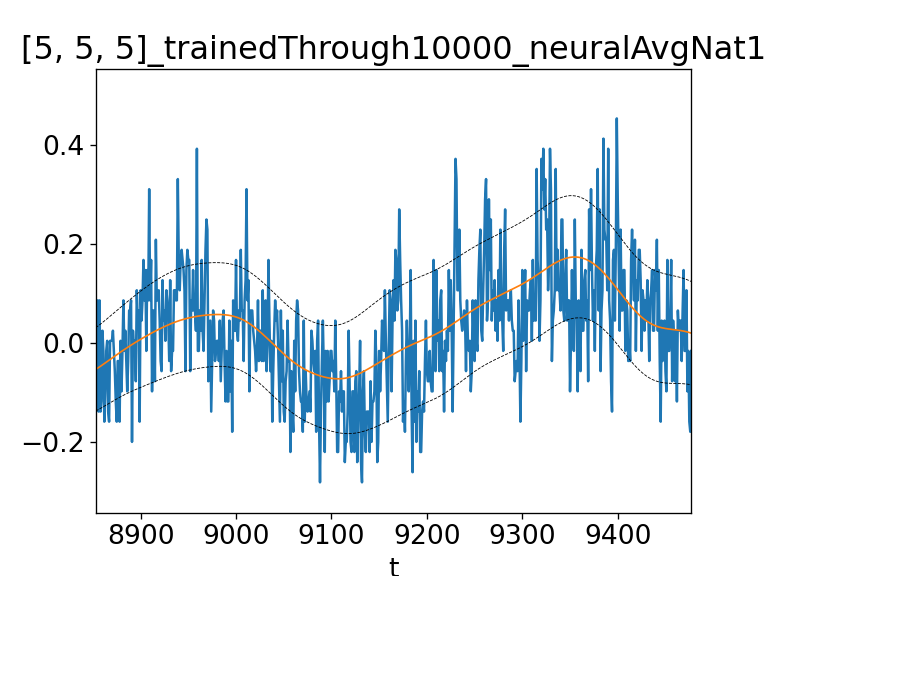

In [183]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="$\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
#     plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
#     plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
#     plt.legend()
    plt.show()

In [158]:
U, S, Vh = np.linalg.svd(responses, full_matrices=False)

In [160]:
cov = responses.T @ responses / (responses.shape[1] - 1)
plt.imshow(cov)
plt.title("covariance: 120 sec movie")
plt.ylabel("unit")
plt.xlabel("unit")
plt.xticks(range(0, 60 ,10))
plt.show()

<IPython.core.display.Javascript object>


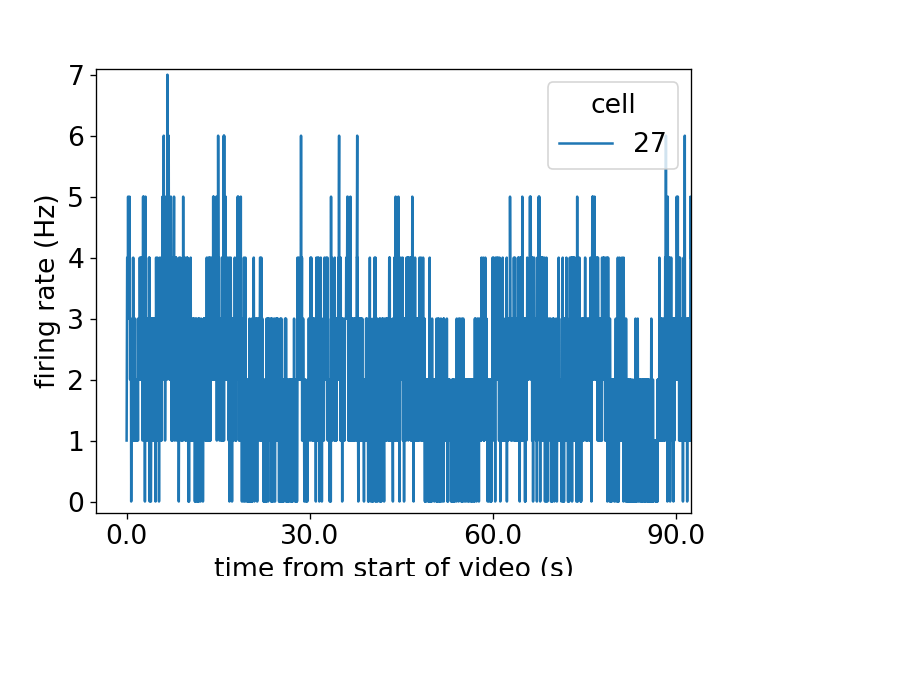

In [181]:
plt.plot(responses[:, 27])
ticks = np.linspace(0, num_bins, 11).astype(int)
plt.xticks(ticks)
ax = plt.gca()
ax.set_xticklabels(np.round(bin_edges[ticks], 1))
plt.ylabel("firing rate (Hz)")
plt.xlabel("time from start of video (s)")
plt.title("")
plt.legend(title="cell", labels=[27], loc="upper right")

In [245]:
variances = S**2 / (avg_resp_c.shape[1] - 1)
cumul_var = sum(variances)
cumul_vars = [0]
rank_hat = None
for i, var in enumerate(variances):
    cumul_vars.append(var + cumul_vars[-1])
    if rank_hat is None and cumul_vars[-1] / cumul_var > 0.9:
        rank_hat = i
rank_hat

27